[Elliptical Galaxies](#1)
[Disk Galaxies](#2)
[Bulgy Disk Galaxies](#3)
[Bulgier Disk Galaxies](#4)

### This code provides the prdictions, feature ranking and a plot of true vs predicted values of galaxy sizes  independent datasets divided by 4 galaxy morphologies: 

### Ellipticals, Disk Galaxies, Bulgy Disks and Bulgier Disks

In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor


In [2]:
import target_predicting_ML_functions_and_feature_ranking as functions

#### <font color='violet'> ML modelling with 33 galaxy and halo features; df from v5 used here


In [3]:
# df here read from the data filtered file from notebook v5, the original dataset before normalization and pruning
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') 

In [4]:
df_log_mass_filtered=df_log_mass_filtered_v5.drop(columns =['GalpropRedshift', 
                                               'GalpropRfric', 'HalopropMaccdot_metal', 'HalopropMaccdot_pristine',
                                               'HalopropMaccdot_reaccreate_metal', 'HalopropMcooldot',
                                               'HalopropMdot_eject', 'HalopropMdot_eject_metal',
                                               'GalpropX', 'GalpropVx','GalpropY', 'GalpropVy',
                                               'GalpropZ', 'GalpropVz', 'GalpropTsat',
                                               'GalpropLogMstar', 'GalpropLogHalfRadius', 'GalpropLogMvir',
                                               'HalopropLogMhot', 'GalpropLogMbulge', 'GalpropLogSfr',
                                               'GalpropLogSfrave100myr', 'GalpropLogSfrave1gyr', 
                                               'GalpropLogSfrave20myr', 'Galprop_neutral_H_mass',
                                               'Galprop_baryon_mass', 'Galprop_gas_fraction',
                                               'GalpropRbulge',  'GalpropRdisk', 'GalpropMvir', 'GalpropMstrip'])

#### define Vvir 

In [5]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as cons


def Delta(z,Om0=0.279,Ob0=0.046,h=0.7):
    #Bryan & Norman 99
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    x=cosmo.Om(z)-1
    return 18*np.pi**2+82*x-39*x**2

def rho_crit(z,Om0=0.279,Ob0=0.046,h=0.7):
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    return cosmo.critical_density(z).to(u.Msun/u.kpc**3).value

def rho_vir(z,Om0=0.279,Ob0=0.046,h=0.7):
    D=Delta(z,Om0=Om0,Ob0=Ob0,h=h)
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    rho_c = cosmo.critical_density(z).to(u.Msun/u.kpc**3).value
    return D*rho_c

def Rvir_to_Mvir(Rvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return rho_v*4./3.*np.pi*Rvir**3   #Msun

def Mvir_to_Rvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return  (Mvir/(rho_v*4./3.*np.pi))**(1./3.)  #kpc

def Mvir_to_Vvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    Rvir = Mvir_to_Rvir(Mvir,z,Om0=Om0,Ob0=Ob0,h=h)
    return (np.sqrt(cons.G*Mvir*u.Msun/(Rvir*u.kpc))).to(u.km/u.s)

In [6]:
# Define Halo property Vvir (as it does not exist in the dataset above)
v= Mvir_to_Vvir (np.array(df_log_mass_filtered.loc[:,'HalopropMvir']),0) # has units

In [7]:
# add Halo property Vvir
df_log_mass_filtered.loc[:, 'HalopropVvir']=v.value # shape of df at this point: df_log_mass_filtered.shape (35390, 36)

In [8]:
df_not_normalized = df_log_mass_filtered.loc[:, :]

In [9]:
df_not_normalized.loc[:, 'BulgeMstar_ratio'] = df_not_normalized.loc[:,'GalpropMbulge']/df_not_normalized.loc[:, 'GalpropMstar']



#### Read the normalized 31-feature dataset (see explanations in related doc 'TNG-SAM 33-feature analysis')

In [10]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

#### Add the column 'BulgeMstar_ratio' defined as Bulge mass / Stellar mass, to be used as a proxy for galaxy morphology

In [11]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']


In [12]:
df_normalized_31.shape

(35390, 33)

In [13]:
df_not_normalized.shape

(35390, 37)

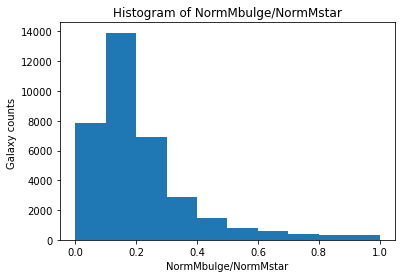

In [14]:
plt.hist(df_normalized_31['BulgeMstar_ratio'])
plt.title('Histogram of NormMbulge/NormMstar')
plt.xlabel('NormMbulge/NormMstar')
plt.ylabel('Galaxy counts ')
# plt.savefig('Histogram of GalpropNormMbulgebyNormMstar.jpg', dpi=500)

plt.show()


## <font color='purple'> <a id =1> </a> <br> Elliptical Galaxies:  B/Mstar > 0.5

In [15]:
df_ellipticals_raw = df_not_normalized[df_not_normalized['BulgeMstar_ratio']>0.5]

In [16]:
df_ellipticals_raw .shape

(2422, 37)

In [17]:
# Looking at the histogram, define elliptical galaxies to be the ones with bulge/mstar>=0.5
df_ellipticals = df_normalized_31[df_normalized_31['BulgeMstar_ratio']>0.5]

# df_ellipticals.to_csv('Ellipticals Dataset_as defined in notebook v13', index=False)

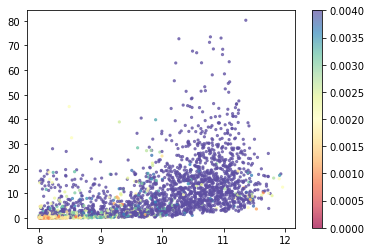

In [18]:
plt.scatter(np.log10(df_ellipticals_raw.loc[:, 'GalpropMstar']), df_ellipticals.loc[:,'GalpropNormHalfRadius'],
            c = df_ellipticals.loc[:, 'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, vmin=0.0, vmax=0.004)
plt.colorbar()
plt.show()

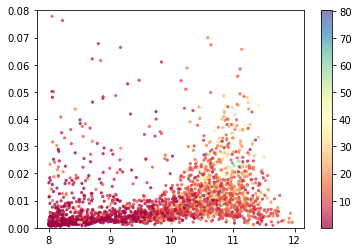

In [19]:
plt.scatter(np.log10(df_ellipticals_raw.loc[:, 'GalpropMstar']),  df_ellipticals.loc[:, 'GalpropNormMstar'],       
            c = df_ellipticals.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7) #, vmin=0.0, vmax=0.004)
plt.ylim(0, 0.08)
plt.colorbar()
plt.show()

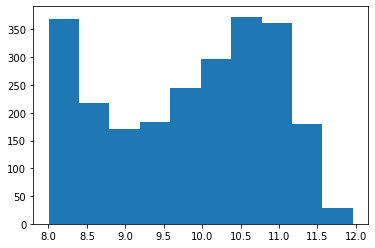

In [20]:
plt.hist(np.log10(df_ellipticals_raw.loc[:, 'GalpropMstar']))
plt.show()

### Normalizing the Ellipticals dataset after removing all galaxies with log10Mstar<=9.0

In [21]:
df_ellipticals_raw.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMu_merger',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMass_ejected',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMstar_diffuse',
 'HalopropMvir',
 'HalopropSpin',
 'HalopropZhot',
 'GalpropHalfRadius',
 'HalopropVvir',
 'BulgeMstar_ratio']

#### remove all galaxies with stellar mass <= 1e9

In [22]:
# remove all galaxies with stellar mass <= 1e9
df_ellipticals_raw = df_ellipticals_raw.loc[df_ellipticals_raw.GalpropMstar>1e9,:]

In [23]:
# 2,422-1,752 = 670 ; that is, there are 670 elliptical galaxies with log10Mstar<=9.0
df_ellipticals_raw.shape

(1752, 37)

#### normalize the dataset - ellipticals_raw

In [24]:
def normalization_func(df):
    '''
    Normalizes the dataset by dividing all masses by halo mass, and galaxy size by halo size

    '''
#     could also use the method below
#     df_log_mass_filtered.loc[:,'GalpropNormMstar']=df_log_mass_filtered.loc[:,'GalpropMstar'].div(df_log_mass_filtered.HalopropMvir, axis=0)
    
    halomass=df.loc[:,'HalopropMvir']
    halorad= df.loc[:,'GalpropRhalo']
    
    df.loc[:,'GalpropNormHalfRadius']=df.loc[:,'GalpropHalfRadius']/halorad
    df.loc[:,'GalpropNormRhalo']=df.loc[:,'GalpropRhalo']/halorad

    df.loc[:,'GalpropNormMstar']=df.loc[:,'GalpropMstar']/halomass
#     df.loc[:,'GalpropNormMvir']=df.loc[:,'GalpropMvir']/halomass
    df.loc[:,'HalopropNormMhot']=df.loc[:,'HalopropMhot']/halomass
    df.loc[:,'GalpropNormMbulge']=df.loc[:,'GalpropMbulge']/halomass
    
    df.loc[:,'GalpropNormMBH']=df.loc[:,'GalpropMBH']/halomass
    df.loc[:,'GalpropNormMH2']=df.loc[:,'GalpropMH2']/halomass
    df.loc[:,'GalpropNormMHI']=df.loc[:,'GalpropMHI']/halomass
    df.loc[:,'GalpropNormMHII']=df.loc[:,'GalpropMHII']/halomass
    df.loc[:,'GalpropNormMcold']=df.loc[:,'GalpropMcold']/halomass
    df.loc[:,'GalpropNormMstar_merge']=df.loc[:,'GalpropMstar_merge']/halomass
#     df.loc[:,'GalpropNormMstrip']=df.loc[:,'GalpropMstrip']/halomass
    
    df.loc[:,'HalopropNormMass_ejected']=df.loc[:,'HalopropMass_ejected']/halomass
    df.loc[:,'HalopropNormMstar_diffuse']=df.loc[:,'HalopropMstar_diffuse']/halomass
    df.loc[:,'HalopropNormMvir']=df.loc[:,'HalopropMvir']/halomass
    
    df.loc[:,'GalpropNormSigmaBulge']=df.loc[:,'GalpropSigmaBulge']/df.loc[:,'HalopropVvir']
    df.loc[:,'GalpropNormVdisk']=df.loc[:,'GalpropVdisk']/df.loc[:,'HalopropVvir']
    
    return df

In [25]:
df_ellipticals_norm=normalization_func(df_ellipticals_raw) # where shape is: df_normalized.shape=(35390, 53)

In [26]:
df_ellipticals_norm.shape

(1752, 53)

In [27]:
# drop the original columns of normalized features + columns used for normalization
df_ellipticals_norm=df_ellipticals_norm.drop(columns=['GalpropHalfRadius',  'GalpropMstar',
 'HalopropMhot','GalpropMbulge','GalpropMBH','GalpropMH2','GalpropMHI','GalpropMHII',
 'GalpropMcold','GalpropMstar_merge','HalopropMass_ejected',
 'HalopropMstar_diffuse','HalopropMvir', 'HalopropNormMvir', 'GalpropRhalo','GalpropNormRhalo', 'HalopropVvir',
                                        'GalpropSigmaBulge', 'GalpropVdisk' ])
# df shape now is: df_normalized.shape =(35390, 34)
# Note, GalpropMaccdot should also be dropped as it is a feature that has 99% of its entries 0s

In [28]:
df_ellipticals_norm = df_ellipticals_norm.drop(columns=['GalpropMaccdot'])

In [29]:
df_ellipticals_norm.shape # dataset where ellipticals have log10Mstar>9.0

(1752, 33)

In [30]:
df_ellipticals.shape # dataset where ellipticals have log10Mstar>8.0

(2422, 33)

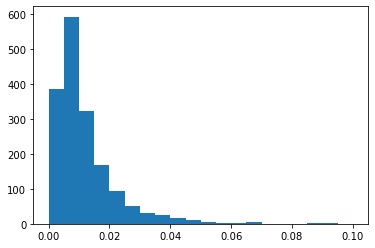

In [31]:
plt.hist(df_ellipticals_norm.loc[:, 'GalpropNormMstar'], range=[0,0.1],bins=20)
plt.show()

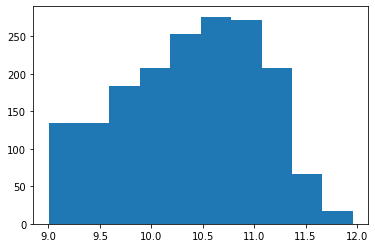

In [32]:
plt.hist(np.log10(df_ellipticals_raw.loc[:, 'GalpropMstar']))
plt.show()

In [33]:
X_ellipticals = df_ellipticals_norm.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_ellipticals = df_ellipticals_norm.loc[:,'GalpropNormHalfRadius']

In [34]:
X_ellipticals.shape

(1752, 31)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.7592 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
RF Accuracy: 0.75 (+/- 0.06)


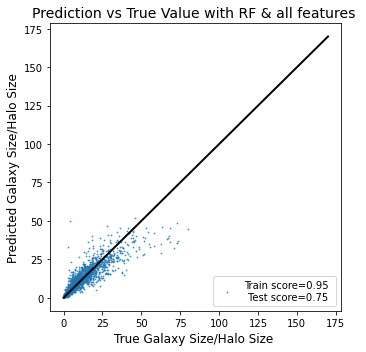

Elapsed time to compute the importances: 0.006 seconds
Elapsed time to compute the importances: 1.437 seconds


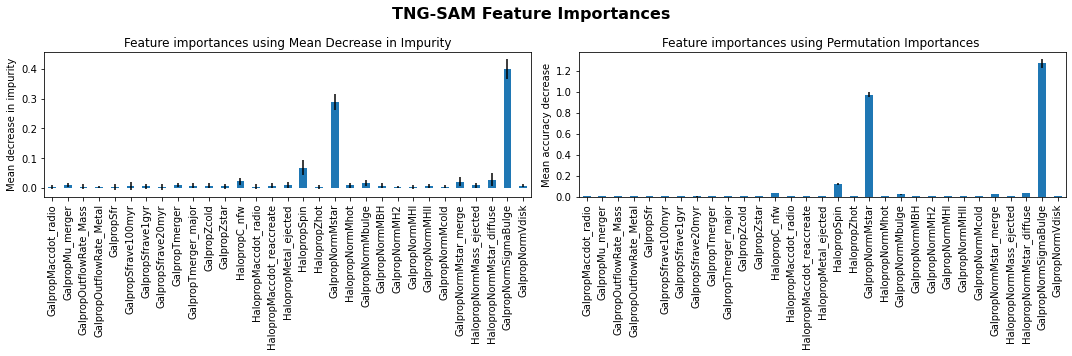

  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/31 [00:00<00:13,  2.25it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/31 [00:00<00:12,  2.26it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▎                                       | 3/31 [00:01<00:11,  2.44it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 4/31 [00:01<00:10,  2.50it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 5/31 [00:02<00:10,  2.53it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▌                                   | 6/31 [00:02<00:09,  2.64it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|█████████▉                                  | 7/31 [00:02<00:08,  2.72it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▎                                | 8/31 [00:03<00:08,  2.68it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 9/31 [00:03<00:08,  2.61it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▊                             | 10/31 [00:03<00:07,  2.76it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                           | 11/31 [00:04<00:07,  2.77it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▋                          | 12/31 [00:04<00:06,  2.73it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████                         | 13/31 [00:04<00:06,  2.76it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▍                       | 14/31 [00:05<00:06,  2.77it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 15/31 [00:05<00:05,  2.74it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 16/31 [00:06<00:05,  2.75it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▌                   | 17/31 [00:06<00:05,  2.67it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▉                  | 18/31 [00:06<00:04,  2.69it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 19/31 [00:07<00:04,  2.82it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▋               | 20/31 [00:07<00:03,  2.90it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 21/31 [00:07<00:03,  2.87it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▌            | 22/31 [00:08<00:02,  3.02it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▉           | 23/31 [00:08<00:02,  2.98it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▎         | 24/31 [00:08<00:02,  2.91it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 25/31 [00:09<00:02,  2.95it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 26/31 [00:09<00:01,  2.87it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▍     | 27/31 [00:09<00:01,  2.82it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▊    | 28/31 [00:10<00:01,  2.83it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▏  | 29/31 [00:10<00:00,  2.81it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 30/31 [00:10<00:00,  2.82it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 31/31 [00:11<00:00,  2.77it/s]


1. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/30 [00:00<00:13,  2.14it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                         | 2/30 [00:00<00:12,  2.16it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 3/30 [00:01<00:12,  2.16it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▊                                      | 4/30 [00:01<00:11,  2.17it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 5/30 [00:02<00:12,  2.08it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 6/30 [00:02<00:11,  2.12it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▎                                 | 7/30 [00:03<00:10,  2.19it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 8/30 [00:03<00:10,  2.19it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 9/30 [00:04<00:09,  2.12it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 10/30 [00:04<00:09,  2.08it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▊                           | 11/30 [00:05<00:09,  2.04it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 12/30 [00:05<00:08,  2.01it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 13/30 [00:06<00:08,  2.04it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████                       | 14/30 [00:06<00:07,  2.03it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 15/30 [00:07<00:07,  2.03it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▉                    | 16/30 [00:07<00:06,  2.14it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 17/30 [00:08<00:06,  2.08it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 18/30 [00:08<00:05,  2.11it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.227, test=0.105) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.385, test=0.080) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.537, test=-0.112) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.556, test=-0.104) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.120, test=-0.023) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.295, test=-0.121) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.516, test=-0.376) total time=   0.1s
[CV 1/

 63%|███████████████████████████▏               | 19/30 [00:09<00:05,  2.09it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 20/30 [00:09<00:04,  2.07it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.215, test=0.109) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.534, test=-0.080) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.526, test=-0.003) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.140, test=-0.012) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.493, test=-0.280) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.504, test=-0.396) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.518, test=-0.369) total time=   0.1s

 70%|██████████████████████████████             | 21/30 [00:10<00:04,  2.03it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▌           | 22/30 [00:10<00:03,  2.01it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|████████████████████████████████▉          | 23/30 [00:11<00:03,  2.00it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.218, test=0.097) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.204, test=0.129) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.511, test=-0.007) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.542, test=-0.064) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.118, test=-0.028) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.318, test=-0.103) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.341, test=-0.118) total time=   0.1s
[CV 3/3]

 80%|██████████████████████████████████▍        | 24/30 [00:11<00:03,  2.00it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.203, test=0.134) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.225, test=0.107) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.551, test=-0.105) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.281, test=-0.131) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.289, test=-0.076) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.506, test=-0.357) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.516, test=-0.282) total time=   0.1s
[CV 1

 83%|███████████████████████████████████▊       | 25/30 [00:12<00:02,  2.04it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.213, test=0.106) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.214, test=0.109) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.393, test=0.038) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.414, test=0.039) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.542, test=-0.081) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.122, test=-0.026) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.297, test=-0.074) total time=   0.2s
[CV 2/3] END

 87%|█████████████████████████████████████▎     | 26/30 [00:12<00:01,  2.07it/s]

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.202, test=0.129) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.381, test=0.079) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.422, test=0.031) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.126, test=0.009) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.125, test=0.016) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.513, test=-0.278) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.191, test=0.054) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=

 90%|██████████████████████████████████████▋    | 27/30 [00:13<00:01,  2.05it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████▏  | 28/30 [00:13<00:00,  2.02it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 29/30 [00:14<00:00,  2.02it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 30/30 [00:14<00:00,  2.07it/s]


2. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▌                                          | 1/29 [00:00<00:16,  1.74it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███                                         | 2/29 [00:01<00:15,  1.79it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▌                                       | 3/29 [00:01<00:15,  1.71it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 4/29 [00:02<00:14,  1.70it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▌                                    | 5/29 [00:02<00:14,  1.68it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████                                   | 6/29 [00:03<00:14,  1.62it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 7/29 [00:04<00:13,  1.63it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 8/29 [00:04<00:12,  1.66it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▋                              | 9/29 [00:05<00:12,  1.65it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 10/29 [00:06<00:11,  1.61it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▎                          | 11/29 [00:06<00:11,  1.57it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▊                         | 12/29 [00:07<00:10,  1.55it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▎                       | 13/29 [00:08<00:10,  1.53it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 14/29 [00:08<00:09,  1.52it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 15/29 [00:09<00:09,  1.51it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 16/29 [00:09<00:08,  1.58it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▏                 | 17/29 [00:10<00:07,  1.67it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▋                | 18/29 [00:11<00:06,  1.69it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 66%|████████████████████████████▏              | 19/29 [00:11<00:05,  1.73it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▋             | 20/29 [00:12<00:05,  1.65it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████████▏           | 21/29 [00:12<00:04,  1.69it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▌          | 22/29 [00:13<00:04,  1.66it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 23/29 [00:14<00:03,  1.69it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 24/29 [00:14<00:02,  1.75it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.643, test=0.309) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.761, test=0.193) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.464, test=0.298) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.668, test=0.230) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.676, test=0.288) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.665, test=0.226) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.673, test=0.214) total time=   0.1s
[CV 3/3] END b

 86%|█████████████████████████████████████      | 25/29 [00:15<00:02,  1.71it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▌    | 26/29 [00:15<00:01,  1.71it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████   | 27/29 [00:16<00:01,  1.67it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 28/29 [00:17<00:00,  1.61it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.659, test=0.233) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.750, test=0.185) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.453, test=0.327) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.455, test=0.315) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.744, test=0.183) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.768, test=0.233) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.445, test=0.312) total time=   0.0s
[CV 2/3] EN

100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.631, test=0.265) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.720, test=0.146) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.486, test=0.182) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.457, test=0.337) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.752, test=0.234) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.753, test=0.206) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.437, test=0.335) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.454, test=0.328) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.463, test=0.327) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.794, test=0.104) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.770, test=0.268) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.455, test=0.324) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.663, test=0.225) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.673, test=0.246) total time=   0.1s
[CV 1/3] END 

  4%|█▌                                          | 1/28 [00:00<00:18,  1.44it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.694, test=0.111) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.462, test=0.295) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.463, test=0.301) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.770, test=0.212) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.764, test=0.239) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.453, test=0.326) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.665, test=0.250) total time=   0.1s
[CV 2/3] END

  7%|███▏                                        | 2/28 [00:01<00:18,  1.44it/s]

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.663, test=0.241) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.471, test=0.311) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.675, test=0.255) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.758, test=0.228) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.515, test=0.208) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.690, test=0.290) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.458, test=0.322) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimator

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.682, test=0.263) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.506, test=0.214) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.708, test=0.142) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.715, test=0.140) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.758, test=0.264) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.799, test=0.114) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.492, test=0.203) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estima

 11%|████▋                                       | 3/28 [00:02<00:18,  1.34it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.663, test=0.242) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.672, test=0.242) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.745, test=0.206) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.761, test=0.202) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.513, test=0.206) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.680, test=0.287) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.647, test=0.273) total time=   0.2s
[CV 2/3] EN

 14%|██████▎                                     | 4/28 [00:02<00:18,  1.30it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 5/28 [00:03<00:18,  1.28it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▍                                  | 6/28 [00:04<00:17,  1.26it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 7/28 [00:05<00:15,  1.32it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 8/28 [00:06<00:15,  1.30it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████▏                             | 9/28 [00:06<00:14,  1.28it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▎                           | 10/28 [00:07<00:14,  1.27it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▉                          | 11/28 [00:08<00:12,  1.31it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▍                        | 12/28 [00:09<00:12,  1.29it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▉                       | 13/28 [00:10<00:11,  1.28it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 14/28 [00:10<00:10,  1.32it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████                    | 15/28 [00:11<00:10,  1.29it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 16/28 [00:12<00:09,  1.27it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████                 | 17/28 [00:13<00:08,  1.25it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▋               | 18/28 [00:13<00:07,  1.30it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 19/28 [00:14<00:07,  1.28it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 20/28 [00:15<00:06,  1.26it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 21/28 [00:16<00:05,  1.30it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▊         | 22/28 [00:17<00:04,  1.28it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▎       | 23/28 [00:17<00:03,  1.27it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 24/28 [00:18<00:03,  1.25it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▍    | 25/28 [00:19<00:02,  1.25it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▉   | 26/28 [00:20<00:01,  1.24it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 27/28 [00:20<00:00,  1.29it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 28/28 [00:21<00:00,  1.29it/s]


4. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/27 [00:00<00:24,  1.06it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▎                                        | 2/27 [00:01<00:23,  1.06it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 3/27 [00:02<00:23,  1.04it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 4/27 [00:03<00:22,  1.04it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▏                                   | 5/27 [00:04<00:19,  1.14it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 6/27 [00:05<00:19,  1.11it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.882, test=0.670) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.899, test=0.656) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.873, test=0.581) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.885, test=0.599) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.899, test=0.594) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.899, test=0.654) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.761, test=0.568) total time=   0.0s
[CV 2/3] E

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.901, test=0.629) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.720, test=0.629) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.876, test=0.634) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.885, test=0.621) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.885, test=0.617) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.756, test=0.598) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.882, test=0.690) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estim

 26%|███████████▍                                | 7/27 [00:06<00:18,  1.08it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.767, test=0.627) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.736, test=0.663) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.884, test=0.686) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.758, test=0.626) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.760, test=0.637) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.908, test=0.627) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.909, test=0.702) total time=   0.2s
[CV 2/3] END

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.908, test=0.671) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.754, test=0.651) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.883, test=0.571) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.901, test=0.645) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.731, test=0.656) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.776, test=0.636) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.908, test=0.661) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estim

 30%|█████████████                               | 8/27 [00:07<00:17,  1.07it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.911, test=0.640) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.753, test=0.672) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.737, test=0.672) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.884, test=0.694) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.905, test=0.647) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.755, test=0.572) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.755, test=0.633) total time=   0.1s
[CV 3/3] END boo

 33%|██████████████▋                             | 9/27 [00:08<00:17,  1.05it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▉                           | 10/27 [00:09<00:16,  1.06it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.754, test=0.659) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.878, test=0.680) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.908, test=0.662) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.756, test=0.665) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.893, test=0.582) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.905, test=0.698) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.901, test=0.660) total time=   0.0s
[CV 3/3] END bo

 41%|█████████████████▌                         | 11/27 [00:10<00:15,  1.06it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.891, test=0.566) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.912, test=0.644) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.890, test=0.661) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.905, test=0.659) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.894, test=0.679) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.919, test=0.660) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.890, test=0.692) total time=   0.0s
[CV 2/

 44%|███████████████████                        | 12/27 [00:11<00:14,  1.05it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 13/27 [00:12<00:13,  1.05it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 14/27 [00:13<00:12,  1.05it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▉                   | 15/27 [00:14<00:11,  1.05it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 16/27 [00:15<00:10,  1.04it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████                | 17/27 [00:16<00:09,  1.05it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 18/27 [00:17<00:08,  1.05it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████▎            | 19/27 [00:17<00:07,  1.05it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 20/27 [00:18<00:06,  1.10it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▍         | 21/27 [00:19<00:05,  1.17it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|███████████████████████████████████        | 22/27 [00:20<00:04,  1.13it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▋      | 23/27 [00:21<00:03,  1.11it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 24/27 [00:22<00:02,  1.09it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▊   | 25/27 [00:23<00:01,  1.08it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 26/27 [00:24<00:00,  1.07it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 27/27 [00:25<00:00,  1.08it/s]


5. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/26 [00:01<00:27,  1.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▍                                        | 2/26 [00:02<00:25,  1.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████                                       | 3/26 [00:03<00:24,  1.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▊                                     | 4/26 [00:04<00:23,  1.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▍                                   | 5/26 [00:05<00:22,  1.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▏                                 | 6/26 [00:06<00:21,  1.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▊                                | 7/26 [00:07<00:20,  1.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▌                              | 8/26 [00:08<00:19,  1.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▏                            | 9/26 [00:09<00:18,  1.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                          | 10/26 [00:10<00:17,  1.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▏                        | 11/26 [00:11<00:15,  1.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▊                       | 12/26 [00:12<00:14,  1.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 13/26 [00:13<00:13,  1.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▏                   | 14/26 [00:14<00:12,  1.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▊                  | 15/26 [00:15<00:11,  1.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▍                | 16/26 [00:16<00:09,  1.01it/s]

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.913, test=0.751) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.919, test=0.752) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.917, test=0.714) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.929, test=0.705) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.756, test=0.685) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.912, test=0.763) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.924, test=0.717) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimato

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.916, test=0.753) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.931, test=0.707) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.779, test=0.637) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.921, test=0.755) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.761, test=0.694) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.777, test=0.656) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.927, test=0.764) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.936, test=0.756) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.755, test=0.655) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.780, test=0.631) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.925, test=0.700) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.921, test=0.721) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.771, test=0.638) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.765, test=0.662) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estima

 65%|████████████████████████████               | 17/26 [00:17<00:09,  1.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.925, test=0.706) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.923, test=0.729) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.779, test=0.665) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.925, test=0.707) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.917, test=0.763) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.787, test=0.646) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.925, test=0.821) total time=   0.2s
[CV 2/3] E

 69%|█████████████████████████████▊             | 18/26 [00:18<00:08,  1.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.919, test=0.794) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.932, test=0.758) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.756, test=0.633) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.914, test=0.741) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.923, test=0.683) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.917, test=0.731) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.924, test=0.683) total time=   0.0s
[CV 1/3] EN

 73%|███████████████████████████████▍           | 19/26 [00:19<00:07,  1.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.925, test=0.759) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.760, test=0.634) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.764, test=0.646) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.929, test=0.707) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.770, test=0.683) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.924, test=0.749) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.923, test=0.774) total time=   0.1s
[CV 2/3] EN

 77%|█████████████████████████████████          | 20/26 [00:20<00:06,  1.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 21/26 [00:21<00:05,  1.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.764, test=0.672) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.914, test=0.740) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.913, test=0.713) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.924, test=0.742) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.760, test=0.698) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.914, test=0.748) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.923, test=0.683) total time=   0.1s
[CV 2/3] END 

 85%|████████████████████████████████████▍      | 22/26 [00:22<00:04,  1.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|██████████████████████████████████████     | 23/26 [00:24<00:03,  1.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▋   | 24/26 [00:25<00:02,  1.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 25/26 [00:26<00:01,  1.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 26/26 [00:27<00:00,  1.04s/it]


6. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/25 [00:01<00:28,  1.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▌                                        | 2/25 [00:02<00:27,  1.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▎                                      | 3/25 [00:03<00:24,  1.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 4/25 [00:04<00:22,  1.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 5/25 [00:05<00:22,  1.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 6/25 [00:06<00:22,  1.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▎                               | 7/25 [00:07<00:20,  1.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 8/25 [00:09<00:19,  1.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▊                            | 9/25 [00:10<00:17,  1.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 10/25 [00:11<00:16,  1.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▉                        | 11/25 [00:12<00:15,  1.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 12/25 [00:13<00:15,  1.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 13/25 [00:14<00:14,  1.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████                   | 14/25 [00:16<00:13,  1.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 15/25 [00:17<00:12,  1.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▌               | 16/25 [00:18<00:10,  1.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 17/25 [00:19<00:09,  1.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▉            | 18/25 [00:21<00:08,  1.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▋          | 19/25 [00:22<00:07,  1.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 20/25 [00:23<00:05,  1.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 21/25 [00:24<00:04,  1.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▊     | 22/25 [00:25<00:03,  1.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▌   | 23/25 [00:26<00:02,  1.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 24/25 [00:27<00:01,  1.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 25/25 [00:29<00:00,  1.16s/it]


7. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.776, test=0.695) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.794, test=0.608) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.941, test=0.775) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.704) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.818, test=0.678) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.944, test=0.807) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.948, test=0.782) total time=   0.2s
[CV 2/3] 

  4%|█▊                                          | 1/24 [00:01<00:30,  1.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▋                                        | 2/24 [00:02<00:29,  1.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.782) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.943, test=0.787) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.781, test=0.687) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.940, test=0.698) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.797, test=0.698) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.944, test=0.783) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.932, test=0.728) total time=   0.1s
[CV 2/3] END

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.935, test=0.771) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.939, test=0.782) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.778, test=0.699) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.933, test=0.762) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.941, test=0.712) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.774) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.815, test=0.673) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.723) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.778, test=0.672) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.792, test=0.607) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.934, test=0.764) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.793, test=0.738) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.940, test=0.777) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.736) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=

 12%|█████▌                                      | 3/24 [00:03<00:28,  1.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 4/24 [00:05<00:26,  1.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.799, test=0.745) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.946, test=0.738) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.821) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.823, test=0.628) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.938, test=0.746) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.944, test=0.816) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.684) total time=   0.3s
[CV 3/3

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.941, test=0.752) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.947, test=0.829) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.803, test=0.674) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.937, test=0.763) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.939, test=0.757) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.771) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.803, test=0.690) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_esti

 21%|█████████▏                                  | 5/24 [00:06<00:23,  1.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 6/24 [00:07<00:23,  1.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 7/24 [00:08<00:20,  1.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 8/24 [00:10<00:20,  1.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                           | 9/24 [00:11<00:19,  1.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|█████████████████▉                         | 10/24 [00:12<00:18,  1.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▋                       | 11/24 [00:14<00:17,  1.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 12/24 [00:15<00:15,  1.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▎                   | 13/24 [00:16<00:14,  1.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|█████████████████████████                  | 14/24 [00:18<00:13,  1.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 15/24 [00:19<00:11,  1.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 16/24 [00:20<00:10,  1.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▍            | 17/24 [00:22<00:09,  1.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 18/24 [00:23<00:08,  1.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 19/24 [00:24<00:06,  1.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 20/24 [00:26<00:05,  1.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 21/24 [00:27<00:04,  1.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▍   | 22/24 [00:28<00:02,  1.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 23/24 [00:30<00:01,  1.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.31s/it]


8. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▉                                          | 1/23 [00:01<00:27,  1.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▊                                        | 2/23 [00:02<00:28,  1.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 3/23 [00:04<00:28,  1.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▋                                    | 4/23 [00:05<00:27,  1.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▌                                  | 5/23 [00:07<00:26,  1.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 6/23 [00:08<00:24,  1.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▍                              | 7/23 [00:10<00:23,  1.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                            | 8/23 [00:11<00:21,  1.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████▏                          | 9/23 [00:12<00:20,  1.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.817, test=0.689) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.787) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.801, test=0.709) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.944, test=0.767) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.943, test=0.752) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.938, test=0.780) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.810, test=0.719) total time=   0.0s
[CV 1/3] END boot

 43%|██████████████████▋                        | 10/23 [00:14<00:19,  1.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▌                      | 11/23 [00:15<00:17,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▍                    | 12/23 [00:17<00:16,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 13/23 [00:18<00:14,  1.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▏                | 14/23 [00:20<00:13,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.930, test=0.762) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.951, test=0.771) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.801, test=0.650) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.776) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.950, test=0.724) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.800, test=0.721) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.795, test=0.679) total time=   0.3s
[CV 2/3] EN

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.782) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.798, test=0.711) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.832, test=0.623) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.663) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.678) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.822, test=0.609) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.932, test=0.754) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estim

 65%|████████████████████████████               | 15/23 [00:21<00:11,  1.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.793, test=0.704) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.937, test=0.796) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.945, test=0.686) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.940, test=0.778) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.812, test=0.717) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.943, test=0.778) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.946, test=0.764) total time=   0.2s
[CV 2/3] END bo

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.716) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.946, test=0.767) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.935, test=0.752) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.762) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.948, test=0.764) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.935, test=0.711) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.712) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_est

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.800, test=0.642) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.937, test=0.773) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.945, test=0.733) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.741) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.809, test=0.724) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.711) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.947, test=0.778) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estim

 70%|█████████████████████████████▉             | 16/23 [00:23<00:10,  1.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 17/23 [00:24<00:08,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.785, test=0.689) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.798, test=0.705) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.949, test=0.766) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.948, test=0.750) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.804, test=0.657) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.736) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.813, test=0.643) total time=   0.1s
[CV 3/3] END 

 78%|█████████████████████████████████▋         | 18/23 [00:26<00:07,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.945, test=0.758) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.950, test=0.796) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.798, test=0.728) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.797) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.811, test=0.721) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.937, test=0.763) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.941, test=0.764) total time=   0.2s
[CV 1/3] END 

 83%|███████████████████████████████████▌       | 19/23 [00:27<00:05,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▍     | 20/23 [00:29<00:04,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████▎   | 21/23 [00:30<00:02,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 22/23 [00:32<00:01,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 23/23 [00:33<00:00,  1.45s/it]


9. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548
	 9 GalpropNormVdisk 0.7679719380739919


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/22 [00:01<00:33,  1.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████                                        | 2/22 [00:02<00:29,  1.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 3/22 [00:04<00:28,  1.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|████████                                    | 4/22 [00:06<00:27,  1.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████                                  | 5/22 [00:07<00:24,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|████████████                                | 6/22 [00:08<00:22,  1.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 7/22 [00:10<00:22,  1.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|████████████████                            | 8/22 [00:11<00:21,  1.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|██████████████████                          | 9/22 [00:13<00:19,  1.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▌                       | 10/22 [00:15<00:18,  1.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 11/22 [00:16<00:17,  1.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▍                   | 12/22 [00:18<00:15,  1.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 13/22 [00:19<00:14,  1.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▎               | 14/22 [00:21<00:12,  1.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▎             | 15/22 [00:22<00:10,  1.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▎           | 16/22 [00:24<00:09,  1.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▏         | 17/22 [00:25<00:07,  1.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▏       | 18/22 [00:27<00:06,  1.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████▏     | 19/22 [00:29<00:04,  1.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████    | 20/22 [00:30<00:03,  1.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|█████████████████████████████████████████  | 21/22 [00:32<00:01,  1.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 22/22 [00:33<00:00,  1.54s/it]


10. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548
	 9 GalpropNormVdisk 0.7679719380739919
	 10 GalpropOutflowRate_Metal 0.7680817947677335


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/21 [00:01<00:34,  1.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.943, test=0.783) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.731) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.791, test=0.657) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.795, test=0.694) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.946, test=0.760) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.948, test=0.765) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.934, test=0.795) total time=   0.1s
[CV 2/3]

 10%|████▏                                       | 2/21 [00:03<00:32,  1.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▎                                     | 3/21 [00:05<00:30,  1.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.814, test=0.686) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.798, test=0.682) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.940, test=0.752) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.787, test=0.718) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.790, test=0.726) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.948, test=0.733) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.951, test=0.721) total time=   0.4s
[CV 1/3] END

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.799, test=0.664) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.724) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.949, test=0.756) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.835, test=0.587) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.945, test=0.639) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.810) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.797, test=0.720) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_esti

 19%|████████▍                                   | 4/21 [00:06<00:27,  1.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.784, test=0.691) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.943, test=0.761) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.944, test=0.743) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.769) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.808, test=0.667) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.813, test=0.680) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.800) total time=   0.4s
[CV 3/3] END

 24%|██████████▍                                 | 5/21 [00:08<00:26,  1.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 6/21 [00:09<00:23,  1.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 7/21 [00:11<00:22,  1.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.943, test=0.736) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.940, test=0.793) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.950, test=0.751) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.806, test=0.695) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.939, test=0.718) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.944, test=0.719) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.778, test=0.689) total time=   0.1s
[CV 1/3] END b

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.949, test=0.764) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.755) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.815, test=0.681) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.754) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.947, test=0.718) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.802) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.929, test=0.753) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_es

 38%|████████████████▊                           | 8/21 [00:13<00:21,  1.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.803, test=0.689) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.806, test=0.693) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.941, test=0.692) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.790) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.817, test=0.630) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.925, test=0.758) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.935, test=0.776) total time=   0.2s
[CV 3/3] END b

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.798, test=0.708) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.939, test=0.781) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.955, test=0.707) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.812, test=0.680) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.811, test=0.685) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.754) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.782) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_esti

 43%|██████████████████▊                         | 9/21 [00:14<00:19,  1.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.667) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.952, test=0.764) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.790, test=0.703) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.936, test=0.720) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.935, test=0.750) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.778) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.793, test=0.710) total time=   0.1s
[CV 3/3] END 

[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.769) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.806, test=0.680) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.711) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.752) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.797, test=0.662) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.803, test=0.674) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.945, test=0.751) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estima

 48%|████████████████████▍                      | 10/21 [00:16<00:17,  1.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▌                    | 11/21 [00:18<00:16,  1.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 12/21 [00:19<00:14,  1.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▌                | 13/21 [00:21<00:13,  1.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 14/21 [00:23<00:11,  1.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 15/21 [00:24<00:10,  1.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▊          | 16/21 [00:26<00:08,  1.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▊        | 17/21 [00:28<00:06,  1.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 18/21 [00:29<00:05,  1.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▉    | 19/21 [00:31<00:03,  1.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▉  | 20/21 [00:33<00:01,  1.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 21/21 [00:34<00:00,  1.66s/it]


11. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548
	 9 GalpropNormVdisk 0.7679719380739919
	 10 GalpropOutflowRate_Metal 0.7680817947677335
	 11 GalpropSfrave20myr 0.7675977117370136


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██▏                                         | 1/20 [00:01<00:34,  1.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 2/20 [00:03<00:32,  1.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 3/20 [00:05<00:31,  1.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 4/20 [00:07<00:27,  1.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 5/20 [00:08<00:26,  1.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 6/20 [00:10<00:25,  1.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▍                            | 7/20 [00:12<00:23,  1.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▌                          | 8/20 [00:14<00:22,  1.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▊                        | 9/20 [00:15<00:18,  1.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 10/20 [00:17<00:17,  1.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 11/20 [00:19<00:16,  1.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 12/20 [00:21<00:14,  1.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▉               | 13/20 [00:23<00:12,  1.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████             | 14/20 [00:24<00:10,  1.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 15/20 [00:26<00:08,  1.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.944, test=0.694) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.758) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.823, test=0.641) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.929, test=0.748) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.722) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.813, test=0.641) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.940, test=0.778) total time=   0.1s
[CV 1/3] 

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.940, test=0.800) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.806, test=0.699) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.938, test=0.740) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.947, test=0.756) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.810, test=0.694) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.947, test=0.747) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.777) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_esti

 80%|██████████████████████████████████▍        | 16/20 [00:28<00:07,  1.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▌      | 17/20 [00:30<00:05,  1.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.730) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.824, test=0.645) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.949, test=0.748) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.749) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.826, test=0.628) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.945, test=0.683) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.765) total time=   0.2s
[CV 3/3] 

 90%|██████████████████████████████████████▋    | 18/20 [00:31<00:03,  1.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▊  | 19/20 [00:33<00:01,  1.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 20/20 [00:35<00:00,  1.78s/it]


12. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548
	 9 GalpropNormVdisk 0.7679719380739919
	 10 GalpropOutflowRate_Metal 0.7680817947677335
	 11 GalpropSfrave20myr 0.7675977117370136
	 12 GalpropNormMBH 0.7696206273180599


  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.809, test=0.642) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.929, test=0.776) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.700) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.942, test=0.780) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.801, test=0.680) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.946, test=0.710) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.947, test=0.784) total time=   0.3s
[CV 1/3] EN

  5%|██▎                                         | 1/19 [00:01<00:30,  1.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▋                                       | 2/19 [00:03<00:31,  1.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.799, test=0.681) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.747) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.950, test=0.716) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.791, test=0.747) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.937, test=0.805) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.950, test=0.768) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.808, test=0.668) total time=   0.3s
[CV 3/3] EN

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.717) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.788, test=0.742) total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.940, test=0.746) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.926, test=0.790) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.698) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.788, test=0.733) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.741) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=

 16%|██████▉                                     | 3/19 [00:05<00:30,  1.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.943, test=0.752) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.943, test=0.706) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.758) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.828, test=0.630) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.938, test=0.808) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.949, test=0.633) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.937, test=0.800) total time=   0.2s
[CV 2/3] E

 21%|█████████▎                                  | 4/19 [00:07<00:27,  1.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.948, test=0.693) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.699) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.800, test=0.669) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.834, test=0.569) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.955, test=0.628) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.744) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.797, test=0.670) total time=   0.3s
[CV 1/3] E

 26%|███████████▌                                | 5/19 [00:09<00:26,  1.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▉                              | 6/19 [00:11<00:24,  1.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.803, test=0.678) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.946, test=0.759) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.946, test=0.751) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.760) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.805, test=0.641) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.938, test=0.721) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.943, test=0.748) total time=   0.2s
[CV 1/3] END 

 37%|████████████████▏                           | 7/19 [00:12<00:21,  1.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▌                         | 8/19 [00:14<00:20,  1.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▊                       | 9/19 [00:16<00:18,  1.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▋                    | 10/19 [00:18<00:17,  1.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▉                  | 11/19 [00:20<00:15,  1.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 12/19 [00:22<00:13,  1.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▍             | 13/19 [00:24<00:11,  1.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▋           | 14/19 [00:26<00:09,  1.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▉         | 15/19 [00:28<00:07,  1.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████▏      | 16/19 [00:30<00:05,  1.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▍    | 17/19 [00:32<00:03,  1.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▋  | 18/19 [00:34<00:01,  1.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 19/19 [00:36<00:00,  1.93s/it]


13. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548
	 9 GalpropNormVdisk 0.7679719380739919
	 10 GalpropOutflowRate_Metal 0.7680817947677335
	 11 GalpropSfrave20myr 0.7675977117370136
	 12 GalpropNormMBH 0.7696206273180599
	 13 GalpropNormMcold 0.7670538411340951


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▍                                         | 1/18 [00:01<00:30,  1.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 2/18 [00:03<00:31,  1.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 3/18 [00:05<00:27,  1.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 4/18 [00:07<00:27,  1.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 5/18 [00:09<00:26,  2.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 6/18 [00:11<00:24,  2.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████                           | 7/18 [00:13<00:21,  1.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████▌                        | 8/18 [00:15<00:19,  2.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|██████████████████████                      | 9/18 [00:17<00:18,  2.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▉                   | 10/18 [00:19<00:15,  1.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 11/18 [00:21<00:14,  2.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 12/18 [00:23<00:12,  2.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.764) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.947, test=0.769) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.951, test=0.736) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.806, test=0.714) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.936, test=0.779) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.779) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.717) total time=   0.4s
[CV 3/3

 72%|███████████████████████████████            | 13/18 [00:26<00:10,  2.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▍         | 14/18 [00:28<00:08,  2.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 15/18 [00:30<00:06,  2.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 16/18 [00:32<00:04,  2.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.790, test=0.706) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.713) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.802, test=0.699) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.795, test=0.734) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.943, test=0.661) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.767) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.813, test=0.663) total time=   0.2s
[CV 1/3] END 

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.945, test=0.773) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.791, test=0.665) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.941, test=0.771) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.943, test=0.719) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.715) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.821, test=0.671) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.723) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimat

 94%|████████████████████████████████████████▌  | 17/18 [00:34<00:02,  2.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 18/18 [00:36<00:00,  2.02s/it]


14. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548
	 9 GalpropNormVdisk 0.7679719380739919
	 10 GalpropOutflowRate_Metal 0.7680817947677335
	 11 GalpropSfrave20myr 0.7675977117370136
	 12 GalpropNormMBH 0.7696206273180599
	 13 GalpropNormMcold 0.7670538411340951
	 14 HalopropC_nfw 0.7635325280300066


  0%|                                                    | 0/17 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.817, test=0.641) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.802, test=0.693) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.947, test=0.722) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.718) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.794, test=0.669) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.681) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.753) total time=   0.4s
[CV 2/3] 

  6%|██▌                                         | 1/17 [00:02<00:35,  2.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.794, test=0.673) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.923, test=0.753) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.935, test=0.760) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.949, test=0.724) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.776) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.814, test=0.616) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.944, test=0.759) total time=   0.3s
[CV 2/3] END 

 12%|█████▏                                      | 2/17 [00:04<00:32,  2.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.942, test=0.771) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.941, test=0.685) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.933, test=0.760) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.947, test=0.759) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.828, test=0.590) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.798) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.815, test=0.634) total time=   0.4s
[CV 1/3] END 

 18%|███████▊                                    | 3/17 [00:06<00:30,  2.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▎                                 | 4/17 [00:08<00:28,  2.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.940, test=0.770) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.936, test=0.763) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.761) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.789, test=0.704) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.941, test=0.751) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.701) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.800, test=0.728) total time=   0.2s
[CV 3/3

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.825, test=0.600) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.941, test=0.745) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.937, test=0.797) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.756) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.815, test=0.645) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.747) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.948, test=0.720) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimat

 29%|████████████▉                               | 5/17 [00:10<00:25,  2.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▌                            | 6/17 [00:12<00:21,  2.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|██████████████████                          | 7/17 [00:14<00:20,  2.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▋                       | 8/17 [00:16<00:19,  2.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|███████████████████████▎                    | 9/17 [00:19<00:17,  2.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▎                 | 10/17 [00:21<00:15,  2.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▊               | 11/17 [00:23<00:13,  2.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▎            | 12/17 [00:25<00:11,  2.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▉          | 13/17 [00:28<00:08,  2.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▍       | 14/17 [00:30<00:06,  2.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▉     | 15/17 [00:32<00:04,  2.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▍  | 16/17 [00:34<00:02,  2.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 17/17 [00:37<00:00,  2.18s/it]


15. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548
	 9 GalpropNormVdisk 0.7679719380739919
	 10 GalpropOutflowRate_Metal 0.7680817947677335
	 11 GalpropSfrave20myr 0.7675977117370136
	 12 GalpropNormMBH 0.7696206273180599
	 13 GalpropNormMcold 0.7670538411340951
	 14 HalopropC_nfw 0.7635325280300066
	 15 HalopropNormMstar_diffuse 0.7641884788296868


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 1/16 [00:02<00:35,  2.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 2/16 [00:04<00:32,  2.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▎                                   | 3/16 [00:06<00:28,  2.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 4/16 [00:08<00:24,  2.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▊                              | 5/16 [00:10<00:22,  2.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                           | 6/16 [00:12<00:21,  2.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████▎                        | 7/16 [00:15<00:19,  2.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|██████████████████████                      | 8/16 [00:17<00:17,  2.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████▊                   | 9/16 [00:19<00:15,  2.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 10/16 [00:21<00:13,  2.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▌             | 11/16 [00:24<00:11,  2.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 12/16 [00:26<00:09,  2.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▉        | 13/16 [00:29<00:06,  2.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 14/16 [00:31<00:04,  2.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.818, test=0.702) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.763) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.826, test=0.596) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.811, test=0.687) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.952, test=0.673) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.944, test=0.778) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.930, test=0.778) total time=   0.1s
[CV 3/3] END 

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.723) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.813, test=0.650) total time=   0.2s


 94%|████████████████████████████████████████▎  | 15/16 [00:33<00:02,  2.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 16/16 [00:35<00:00,  2.23s/it]


16. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548
	 9 GalpropNormVdisk 0.7679719380739919
	 10 GalpropOutflowRate_Metal 0.7680817947677335
	 11 GalpropSfrave20myr 0.7675977117370136
	 12 GalpropNormMBH 0.7696206273180599
	 13 GalpropNormMcold 0.7670538411340951
	 14 HalopropC_nfw 0.7635325280300066
	 15 HalopropNormMstar_diffuse 0.7641884788296868
	 16 HalopropZhot 0.7671666732478246


  0%|                                                    | 0/15 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.946, test=0.738) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.783, test=0.701) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.811, test=0.705) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.945, test=0.753) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.779, test=0.700) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.787, test=0.703) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.947, test=0.732) total time=   0.3s
[CV 3/3] END boo

  7%|██▉                                         | 1/15 [00:02<00:34,  2.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.800, test=0.661) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.683) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.936, test=0.746) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.947, test=0.759) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.793, test=0.729) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.954, test=0.689) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.788) total time=   0.3s
[CV 3/3] END

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.939, test=0.764) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.941, test=0.793) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.803, test=0.668) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.930, test=0.762) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.935, test=0.757) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.943, test=0.773) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.820, test=0.677) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators

 13%|█████▊                                      | 2/15 [00:04<00:32,  2.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 3/15 [00:07<00:29,  2.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 4/15 [00:09<00:27,  2.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.817, test=0.633) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.737) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.804, test=0.668) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.693) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.830, test=0.615) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.795, test=0.723) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.956, test=0.700) total time=   0.6s
[CV 1/3] END boo

 33%|██████████████▋                             | 5/15 [00:12<00:24,  2.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.801, test=0.672) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.941, test=0.751) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.950, test=0.757) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.832, test=0.626) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.937, test=0.788) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.961, test=0.700) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.945, test=0.796) total time=   0.5s
[CV 3/3] EN

 40%|█████████████████▌                          | 6/15 [00:14<00:21,  2.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▌                       | 7/15 [00:16<00:19,  2.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.767) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.805, test=0.656) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.941, test=0.704) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.936, test=0.759) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.942, test=0.699) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.810, test=0.660) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.943, test=0.731) total time=   0.1s
[CV 1/3] END b

 53%|███████████████████████▍                    | 8/15 [00:19<00:16,  2.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|██████████████████████████▍                 | 9/15 [00:21<00:14,  2.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 10/15 [00:23<00:11,  2.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.697) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.802, test=0.649) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.678) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.933, test=0.781) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.720) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.811, test=0.705) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.700) total time=   0.3s
[CV 2/3] END b

 73%|███████████████████████████████▌           | 11/15 [00:26<00:09,  2.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 12/15 [00:28<00:07,  2.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▎     | 13/15 [00:30<00:04,  2.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████▏  | 14/15 [00:33<00:02,  2.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 15/15 [00:35<00:00,  2.40s/it]

17. iteration: 
	 1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548
	 9 GalpropNormVdisk 0.7679719380739919
	 10 GalpropOutflowRate_Metal 0.7680817947677335
	 11 GalpropSfrave20myr 0.7675977117370136
	 12 GalpropNormMBH 0.7696206273180599
	 13 GalpropNormMcold 0.7670538411340951
	 14 HalopropC_nfw 0.7635325280300066
	 15 HalopropNormMstar_diffuse 0.7641884788296868
	 16 HalopropZhot 0.7671666732478246
	 17 GalpropMu_merger 0.7701164063072529


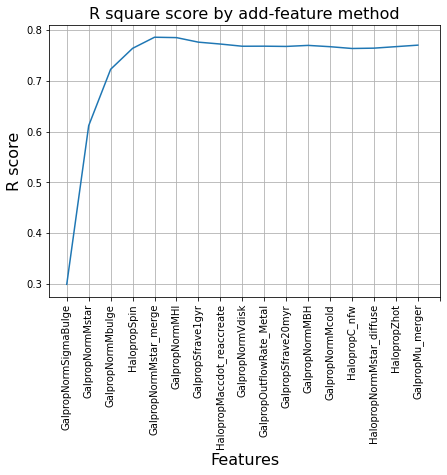

Elapsed time to run RF func on Ellipticals: 525.575 seconds


In [35]:
# Note: It takes about ~541.622 seconds = 9 min to run this block of code on ellipticals
start_time = time.time()

ellipticals_RF_results = functions.target_predicting_RF_function(X_ellipticals, y_ellipticals)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on Ellipticals: {elapsed_time:.3f} seconds")

#### The most important features for Elliptical galaxies (dataset with log10Mstar>9.0) are:

     1 GalpropNormSigmaBulge 0.2990714623617346
	 2 GalpropNormMstar 0.6115947546556708
	 3 GalpropNormMbulge 0.7225814214700482
	 4 HalopropSpin 0.7638037809869207
	 5 GalpropNormMstar_merge 0.7857087499379404
	 6 GalpropNormMHI 0.7849478954536555
	 7 GalpropSfrave1gyr 0.776004424397364
	 8 HalopropMaccdot_reaccreate 0.7722967081739548
	 9 GalpropNormVdisk 0.7679719380739919
	 10 GalpropOutflowRate_Metal 0.7680817947677335
	 11 GalpropSfrave20myr 0.7675977117370136
	 12 GalpropNormMBH 0.7696206273180599
	 13 GalpropNormMcold 0.7670538411340951
	 14 HalopropC_nfw 0.7635325280300066
	 15 HalopropNormMstar_diffuse 0.7641884788296868
	 16 HalopropZhot 0.7671666732478246
	 17 GalpropMu_merger 0.7701164063072529

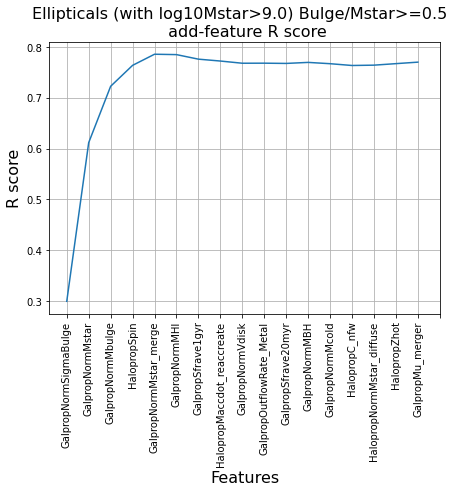

In [36]:
fig_add_feature_ellipticals=ellipticals_RF_results[4].plot(x='features', y='r_sq_score', 
                                                     rot=90, figsize=(7,5), use_index=True,
                                                     legend=False, grid=True, 
                                                     xticks=range(0,18))
fig_add_feature_ellipticals.set_title(label= 'Ellipticals (with log10Mstar>9.0) Bulge/Mstar>=0.5  \n add-feature R score',fontsize=16)
fig_add_feature_ellipticals.set_xlabel('Features',fontsize=16)
fig_add_feature_ellipticals.set_ylabel('R score',fontsize=16)

# fig_add_feature_ellipticals.get_figure().savefig('Ellipticals_logMstar9_R score by add-feature method.jpg', dpi=500)

plt.show()

In [37]:
# ellipticals_RF_results[4].to_csv('Ellipticals_logMstar9_Max r scores by add column method.csv', index=False)

In [38]:
# ellipticals = pd.read_csv('Ellipticals_logMstar9_Max r scores by add column method.csv')

In [39]:
fig_ellipticals = ellipticals_RF_results[1]
# fig_ellipticals.savefig('Ellipticals_logMstar9_RF Prediction_vs_True.jpeg', dpi=500)
plt.show()

In [41]:
fig_builtin_imp_ellipticals = ellipticals_RF_results[2]
# fig_builtin_imp_ellipticals.savefig('Ellipticals_logMstar9_Built-in Feature Ranking.jpeg', dpi=500)
plt.show()

### Exploring relations between first imp features to extract the physical model for ellipticals

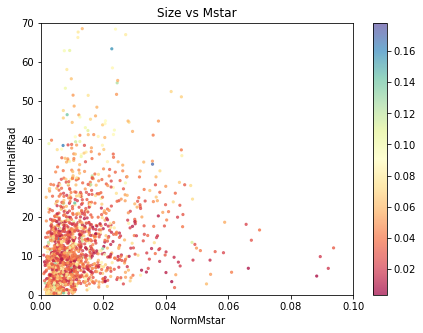

In [42]:
fig, ax = plt.subplots (nrows=1, ncols=1, figsize = (7,5))
fig1= ax.scatter(df_ellipticals_norm.loc[:, 'GalpropNormMstar'], df_ellipticals_norm.loc[:,'GalpropNormHalfRadius'],
            c = df_ellipticals_norm.loc[:, 'HalopropSpin'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7) #, vmin=0.0, vmax=0.004)
ax.set(xlabel = 'NormMstar', ylabel = 'NormHalfRad',
       title = 'Size vs Mstar',
       xlim = (0, 0.1), ylim=(0, 70))
fig.colorbar(fig1, ax=ax)
plt.show()

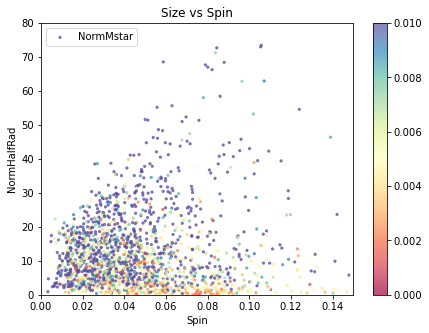

In [43]:
fig, ax = plt.subplots (nrows=1, ncols=1, figsize = (7,5))
fig1= ax.scatter(df_ellipticals_norm.loc[:, 'HalopropSpin'], df_ellipticals_norm.loc[:,'GalpropNormHalfRadius'],
            c = df_ellipticals_norm.loc[:, 'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label ='NormMstar', vmin=0.0, vmax=0.01)
ax.set(xlabel = 'Spin', ylabel = 'NormHalfRad',
       title = 'Size vs Spin',
       xlim = (0, 0.15), ylim=(0, 80))
ax.legend(loc='upper left')
fig.colorbar(fig1, ax=ax)
# fig.savefig('Ellipticals__logMstar9_Size_vs_Spin_colorbar_NormMstar.jpeg', dpi=500)
plt.show()

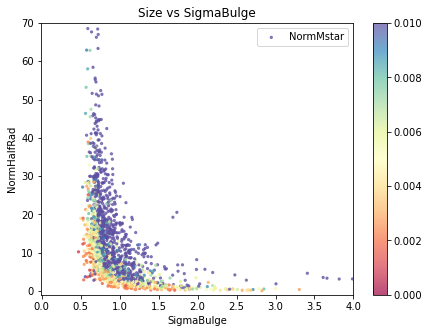

In [44]:
fig, ax = plt.subplots (nrows=1, ncols=1, figsize = (7,5))
fig1= ax.scatter(df_ellipticals_norm.loc[:, 'GalpropNormSigmaBulge'], df_ellipticals_norm.loc[:,'GalpropNormHalfRadius'],
            c = df_ellipticals_norm.loc[:, 'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label ='NormMstar', vmin=0.0, vmax=0.01)
ax.set(xlabel = 'SigmaBulge', ylabel = 'NormHalfRad',
       title = 'Size vs SigmaBulge',
       xlim = (-0.01 , 4.0), ylim=(-1.0, 70))
ax.legend(loc='upper right')
fig.colorbar(fig1, ax=ax)
# fig.savefig('Ellipticals__logMstar9_Size_vs_SigmaBulge_colorbar_NormMstar1.jpeg', dpi=500)
plt.show()

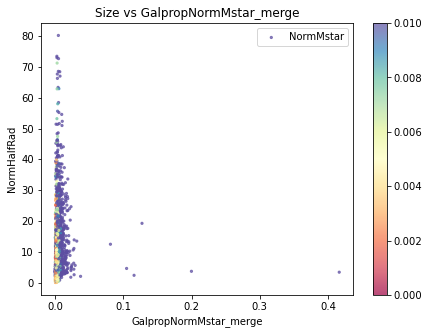

In [45]:
fig, ax = plt.subplots (nrows=1, ncols=1, figsize = (7,5))
fig1= ax.scatter(df_ellipticals_norm.loc[:, 'GalpropNormMstar_merge'], df_ellipticals_norm.loc[:,'GalpropNormHalfRadius'],
            c = df_ellipticals_norm.loc[:, 'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label ='NormMstar', vmin=0.0, vmax=0.01)
ax.set(xlabel = 'GalpropNormMstar_merge', ylabel = 'NormHalfRad',
       title = 'Size vs GalpropNormMstar_merge') #, xlim = (-0.005 , 0.04), ylim=(-1.0, 70))
ax.legend(loc='upper right')
fig.colorbar(fig1, ax=ax)
# fig.savefig('Ellipticals__logMstar9_Size_vs_GalpropNormMstar_merge_colorbar_NormMstar.jpeg', dpi=500)
plt.show()

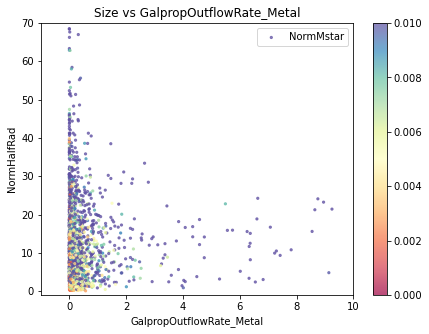

In [46]:

fig, ax = plt.subplots (nrows=1, ncols=1, figsize = (7,5))
fig1= ax.scatter(df_ellipticals_norm.loc[:, 'GalpropOutflowRate_Metal'], df_ellipticals_norm.loc[:,'GalpropNormHalfRadius'],
            c = df_ellipticals_norm.loc[:, 'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label ='NormMstar', vmin=0.0, vmax=0.01)
ax.set(xlabel = 'GalpropOutflowRate_Metal', ylabel = 'NormHalfRad',
       title = 'Size vs GalpropOutflowRate_Metal', xlim = (-1.0 , 10.0), ylim=(-1.0, 70))
ax.legend(loc='upper right')
fig.colorbar(fig1, ax=ax)
# fig.savefig('Ellipticals__logMstar9_Size_vs_GalpropOutflowRate_Metal_colorbar_NormMstar1.jpeg', dpi=500)
plt.show()

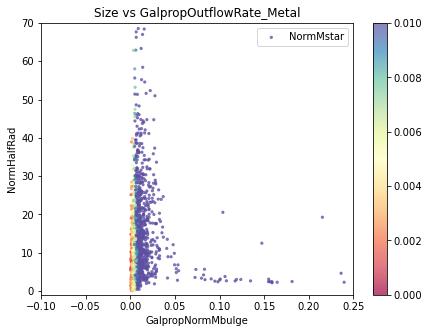

In [47]:

fig, ax = plt.subplots (nrows=1, ncols=1, figsize = (7,5))
fig1= ax.scatter(df_ellipticals_norm.loc[:, 'GalpropNormMbulge'], df_ellipticals_norm.loc[:,'GalpropNormHalfRadius'],
            c = df_ellipticals_norm.loc[:, 'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label ='NormMstar', vmin=0.0, vmax=0.01)
ax.set(xlabel = 'GalpropNormMbulge', ylabel = 'NormHalfRad',
       title = 'Size vs GalpropOutflowRate_Metal', xlim = (-0.1 , 0.25), ylim=(-1.0, 70))
ax.legend(loc='upper right')
fig.colorbar(fig1, ax=ax)
# fig.savefig('Ellipticals__logMstar9_Size_vs_GalpropNormMbulge_colorbar_NormMstar1.jpeg', dpi=500)
plt.show()

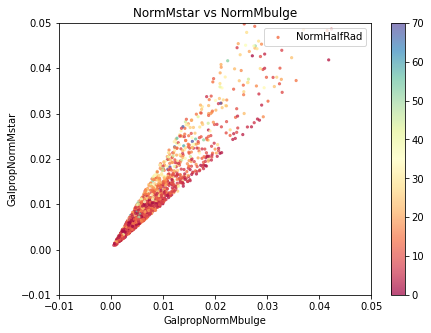

In [58]:
fig, ax = plt.subplots (nrows=1, ncols=1, figsize = (7,5))
fig1= ax.scatter(df_ellipticals_norm.loc[:, 'GalpropNormMbulge'], df_ellipticals_norm.loc[:,'GalpropNormMstar'],
            c = df_ellipticals_norm.loc[:, 'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label ='NormHalfRad', vmin=0.0, vmax=70)
ax.set(xlabel = 'GalpropNormMbulge', ylabel = 'GalpropNormMstar',
       title = 'NormMstar vs NormMbulge', xlim = (-0.01 , 0.05), ylim=(-0.01, 0.05))
ax.legend(loc='upper right')
fig.colorbar(fig1, ax=ax)
# fig.savefig('Ellipticals__logMstar9_Size_vs_GalpropNormMbulge_colorbar_NormMstar1.jpeg', dpi=500)
plt.show()

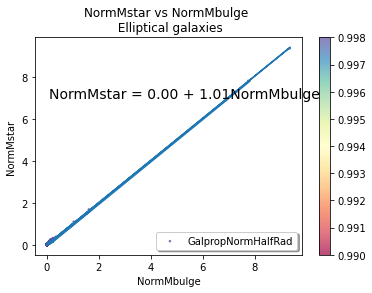

In [53]:
#find line of best fit
a1, b1 = np.polyfit(df_ellipticals_norm.loc[:, 'GalpropNormMbulge'], df_ellipticals_norm.loc[:,'GalpropNormMstar'], 1)

plt.scatter(df_ellipticals_norm.loc[:, 'GalpropNormMbulge'], df_ellipticals_norm.loc[:,'GalpropNormMstar'],
            c = df_ellipticals_norm.loc[:, 'GalpropNormHalfRadius'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormHalfRad', vmin=0.99, vmax=0.998)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.12])
plt.title('NormMstar vs NormMbulge \n Elliptical galaxies')
plt.xlabel('NormMbulge')
plt.ylabel('NormMstar ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_ellipticals_norm.loc[:,'GalpropNormMstar'], a1*df_ellipticals_norm.loc[:, 'GalpropNormMbulge']+b1) 
#add fitted regression equation to plot
plt.text(0.1, 7, 'NormMstar = ' + '{:.2f}'.format(b1) + ' + {:.2f}'.format(a1) + 'NormMbulge', size=14)

# plt.savefig('Ellipticals__logMstar9_NormMstar_vs_NormMbulge_polyfit.jpeg', dpi=500)
plt.show()

In [61]:
df_ellipticals_norm_wooutliers = df_ellipticals_norm.loc[df_ellipticals_norm.GalpropNormMstar<=0.05,:]

In [62]:
df_ellipticals_norm_wooutliers.shape # 52 galaxies are outliers

(1700, 33)

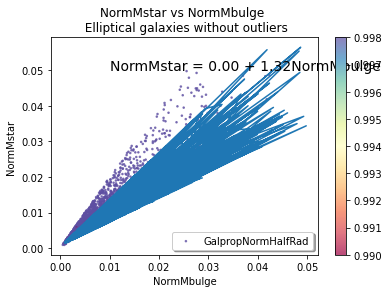

In [66]:
#find line of best fit
a2, b2 = np.polyfit(df_ellipticals_norm_wooutliers.loc[:, 'GalpropNormMbulge'], df_ellipticals_norm_wooutliers.loc[:,'GalpropNormMstar'], 1)

plt.scatter(df_ellipticals_norm_wooutliers.loc[:, 'GalpropNormMbulge'], df_ellipticals_norm_wooutliers.loc[:,'GalpropNormMstar'],
            c = df_ellipticals_norm_wooutliers.loc[:, 'GalpropNormHalfRadius'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormHalfRad', vmin=0.99, vmax=0.998)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.12])
plt.title('NormMstar vs NormMbulge \n Elliptical galaxies without outliers')
plt.xlabel('NormMbulge')
plt.ylabel('NormMstar ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_ellipticals_norm_wooutliers.loc[:,'GalpropNormMstar'], a2*df_ellipticals_norm_wooutliers.loc[:, 'GalpropNormMbulge']+b2) 
#add fitted regression equation to plot
plt.text(0.01, 0.05, 'NormMstar = ' + '{:.2f}'.format(b2) + ' + {:.2f}'.format(a2) + 'NormMbulge', size=14)

# plt.savefig('Ellipticals__logMstar9_NormMstar_vs_NormMbulge_polyfit.jpeg', dpi=500)
plt.show()

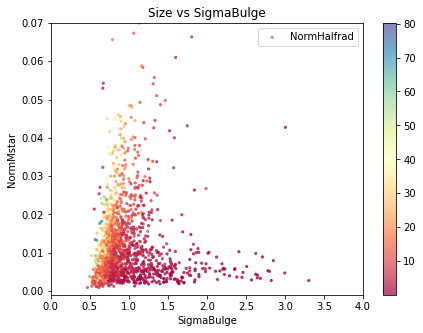

In [75]:
fig, ax = plt.subplots (nrows=1, ncols=1, figsize = (7,5))
fig1= ax.scatter(df_ellipticals_norm.loc[:, 'GalpropNormSigmaBulge'], df_ellipticals_norm.loc[:,'GalpropNormMstar'],
            c = df_ellipticals_norm.loc[:, 'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label ='NormHalfrad') #, vmin=0.0, vmax=0.01)
ax.set(xlabel = 'SigmaBulge', ylabel = 'NormMstar',
       title = 'Size vs SigmaBulge',xlim = (-0.001 , 4.0), ylim=(-0.001, 0.07))
ax.legend(loc='upper right')
fig.colorbar(fig1, ax=ax)
# fig.savefig('Ellipticals__logMstar9_NormMstar_vs_SigmaBulge_colorbar_Size1.jpeg', dpi=500)
plt.show()

### <font color='darkred'> Conclusion: There doesn't seem to be a trivial relation between variables that could lead to a physical model for ellipticals

### Previous results when using ellipticals with log10Mstar>8.0

#### The most important features for Elliptical galaxies are:
     1. GalpropNormSigmaBulge 0.3789379492782892
	 2. GalpropNormMstar 0.631757029671015
	 3. GalpropNormMstar_merge 0.7652099704860734
	 4. HalopropSpin 0.7955678873644985
	 5. HalopropC_nfw 0.8115313899592044
	 6. GalpropNormMbulge 0.8120989883559749
	 7. HalopropMetal_ejected 0.8262629080067674
	 8. HalopropZhot 0.8219497719044462
	 9. GalpropOutflowRate_Mass 0.8208638284612834
	 10. GalpropSfrave100myr 0.8167890600318248
	 11. GalpropNormMHII 0.822752879811922

In [19]:
ellipticals_RF_results[4]

,feature_number,features,r_sq_score
0,1,GalpropNormSigmaBulge,0.378938
1,2,GalpropNormMstar,0.631757
2,3,GalpropNormMstar_merge,0.765210
3,4,HalopropSpin,0.795568
4,5,HalopropC_nfw,0.811531
5,6,GalpropNormMbulge,0.812099
6,7,HalopropMetal_ejected,0.826263
7,8,HalopropZhot,0.821950
8,9,GalpropOutflowRate_Mass,0.820864
9,10,GalpropSfrave100myr,0.816789


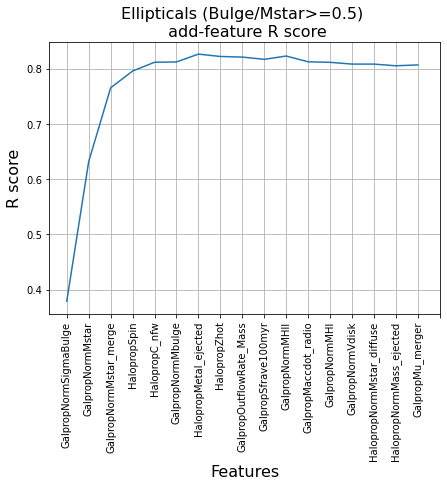

In [21]:
fig_add_feature_ellipticals=ellipticals_RF_results[4].plot(x='features', y='r_sq_score', 
                                                     rot=90, figsize=(7,5), use_index=True,
                                                     legend=False, grid=True, 
                                                     xticks=range(0,18))
fig_add_feature_ellipticals.set_title(label= 'Ellipticals (Bulge/Mstar>=0.5) \n add-feature R score',fontsize=16)
fig_add_feature_ellipticals.set_xlabel('Features',fontsize=16)
fig_add_feature_ellipticals.set_ylabel('R score',fontsize=16)

# fig_add_feature_ellipticals.get_figure().savefig('Ellipticals R score by add-feature method.jpg', dpi=500)

plt.show()

In [22]:
# ellipticals_RF_results[4].to_csv('Ellipticals Max r scores by add column method.csv', index=False)

In [23]:
# ellipticals = pd.read_csv('Ellipticals Max r scores by add column method.csv')

In [25]:
fig_ellipticals = ellipticals_RF_results[1]
# fig_ellipticals.savefig('Ellipticals RF Prediction_vs_True.jpeg', dpi=500)
plt.show()

In [26]:
fig_builtin_imp_ellipticals = ellipticals_RF_results[2]
# fig_builtin_imp_ellipticals.savefig('Ellipticals Built-in Feature Ranking.jpeg', dpi=500)
plt.show()